<a id="tercero"></a>
## 3. Entendimiento de imágenes de personas

El problema de inferir ciertas características de una persona a través de una foto de ella puede resultar bastante dificil incluso para nosotros, como por ejemplo de qué país es, la emoción que expresa, la edad que tiene, o el género. La automatización de este proceso para que máquinas logren identificar ciertas características de una persona puede ser algo crucial para el futuro desarrollo de Inteligencia Artificial.


<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />


En esta actividad trabajaremos con unos datos (imágenes) con la tarea de predecir la **edad** (*target value*) de la persona en la imagen. Los datos con corresponden a 3640 imágenes de Flickr de rostros de personas, pero, debido a que trabajamos con redes *feed forward*, se trabajará con representaciones de características extraídas. Para ésto necesitará descargar los datos del siguiente __[link](http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html)__ en el extracto de *ageGenderClassification* o a través de la consola Unix.
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/ageGenderClassification.zip
```

Se trabajará con archivos *.mat* que pueden ser cargados de la siguiente manera:
```python
import scipy.io as sio
sio.loadmat("file.mat")
```

Para descripción sobre las columnas están en el archivo readme a través del siguiente __[link](http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt)__ o a través de la consola Unix:
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt
```


> a) Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?
```python
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]
```

> b) Eliga cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo neuronal denso. Además extraiga las etiquetas del problema. Describa los datos utilziados.
```python
genFeat = data[0]  #it can be used as representation: contextual features
ageClass = data[1] #target
ffcoefs = data[3]   #it can be used as representation: fisherface space
faceGist = data[4]  #it can be used as representation
```

> c) Defina y entrene una modelo de red neuronal *feed forward* para la inferencia de la edad de la persona a través de la representación escogida. Intente llegar a un *mse* menor a 100 en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.


*Nota: Puede notar que la cantidad de edades presentes en el problema son pocas (1,  5, 10, 16, 28, 51 o 75 años), por lo que puede tratar al problema así como de regresión o clasificación (considerando cada edad como una clase)*


#### Ayuda:
> Para problemas de clasificación de múltiples clases es necesario transformar las etiquetas categóricas en *one hot vector*, donde cada columna del vector representará una categoría. Por ejemplo, si existen tres categorías (perro, gato, ratón), la categoría perro puede ser codificada como [1,0,0], y la categoría ratón puede ser codificada como [0,0,1]. Para ésto la librería *keras* nos ayuda:

```python
import keras
y_onehot = keras.utils.to_categorical(y_train,num_classes=edades_distintas)
```

In [15]:
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]

In [151]:
data

array([[ 4.20000000e+01,  3.40000000e+01,  3.00000000e+00, ...,
         1.05718040e+02,  1.87811527e+01,  3.06854736e+02],
       [ 6.00000000e+01,  1.20000000e+01,  1.00000000e+00, ...,
         1.51088806e+02, -3.41068054e+02,  9.30533905e+01],
       [ 2.90000000e+01,  3.50000000e+01,  2.00000000e+00, ...,
         1.51514084e+02,  1.57356903e+02,  2.35412140e+02],
       ...,
       [ 6.30000000e+01,  3.90000000e+01,  2.00000000e+00, ...,
         1.80594995e+03,  7.68546997e+02, -2.29365768e+02],
       [ 5.70000000e+01,  8.10000000e+01,  1.00000000e+00, ...,
        -1.05423975e+03, -1.09025903e+03, -1.49180969e+02],
       [ 3.00000000e+01,  6.10000000e+01,  1.00000000e+00, ...,
         5.14633118e+02, -1.44830612e+02, -1.82602676e+02]])

In [168]:
genFeat = data_train[0]  #it can be used as representation: contextual features
ageClass = data_train[1] #target
ffcoefs = data_train[3]   #it can be used as representation: fisherface space
faceGist = data_train[4]  #it can be used as representation
print(data_train[2].shape)
print(data_train[5])

(3500, 1)
[[104 108 112 ...  83  80  82]
 [237 197 118 ... 186 219 226]
 [ 66  66  55 ...  82  77  65]
 ...
 [ 50  52  36 ...  65  70  70]
 [ 63  48  62 ... 148 153 157]
 [124 127 131 ...  89 134 182]]


In [316]:
np.mean((targets.astype(int) - 5)**2)

1101.0

In [33]:
    import numpy as np
    data = np.concatenate((genFeat,ffcoefs,faceGist),axis=1)
    targets = ageClass

In [85]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.layers import Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1,l2
import numpy as np
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]

genFeat = data_train[0]  #it can be used as representation: contextual features
ageClass = data_train[1] #target
ffcoefs = data_train[3]   #it can be used as representation: fisherface space
faceGist = data_train[4]  #it can be used as representation

 
data = np.concatenate((genFeat,ffcoefs,faceGist),axis=1)
targets = ageClass.reshape(-1)
target_to_class = {'1':0,'5':1,'10':2,'16':3,'28':4,'51':5,'75':6}
classes = np.zeros(len(targets))
targets_vector = [1,5,10,16,28,51,75]

for i in range(len(targets)):
    classes[i] = target_to_class[str(targets[i])]


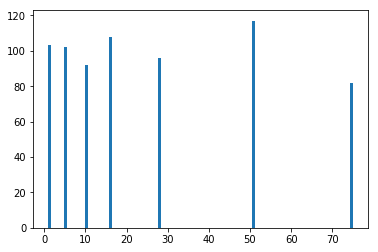

In [82]:
plt.hist(targets[test_index],bins= 100)
plt.show()

In [344]:
results_file = open('pregunta3_results/results.txt', 'r')
results = []
for row in results_file:
    results.append(row.replace('t_u','t--u').replace('e_u','e--u').strip('\n').split('_'))
    
results_file_dropout = open('pregunta3_results/dropout_results.txt', 'r')
results_dropout = []
for row in results_file_dropout:
    results_dropout.append(row.replace('t_u','t--u').replace('e_u','e--u').strip('\n').split('_'))

In [349]:
results = pd.DataFrame(results)
results.columns = ['n_layers', 'neurons','activation','initializer','learning_rate','epochs','mse','val_mse','accuracy']
results_dropout = pd.DataFrame(results_dropout)
results_dropout.columns = ['n_layers', 'neurons','activation','initializer','learning_rate','epochs','mse','val_mse','accuracy']


0                      1
1                     10
2                   relu
3        glorot--uniform
4                 0.0001
5                   1000
6     1005.8607142857143
7                1007.76
8    0.13428571428571429
dtype: object

In [327]:
pd.to_numeric(results, errors='ignore')

array([], dtype=int64)

In [320]:
results[['n_layers', 'neurons','learning_rate','epochs','mse','val_mse','accuracy']] = \
results[['n_layers', 'neurons','learning_rate','epochs','mse','val_mse','accuracy']].apply(pd.to_numeric)

In [348]:
results_dropout[['n_layers', 'neurons','learning_rate','epochs','mse','val_mse','accuracy']] = \
results_dropout[['n_layers', 'neurons','learning_rate','epochs','mse','val_mse','accuracy']].apply(pd.to_numeric)

KeyError: "['n_layers' 'neurons' 'learning_rate' 'epochs' 'mse' 'val_mse' 'accuracy'] not in index"

In [307]:
results['']

KeyError: 'Column not found: 0'